#Load Libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn import preprocessing
from sklearn import metrics
from sklearn.learning_curve import learning_curve

#Load Data

In [2]:
training = pd.read_csv('train.csv')
training = training.reindex(np.random.permutation(training.index))

breakpoint = int(0.8 * training.shape[0])

train_data = training.copy()[:breakpoint]
valid_data = training.copy()[breakpoint:]

test_data = pd.read_csv('test.csv')

for col in ['Elevation', 'Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm']:
    train_data[col] = preprocessing.scale(train_data[col].values.astype(float))
    valid_data[col] = preprocessing.scale(valid_data[col].values.astype(float))
    test_data[col] = preprocessing.scale(test_data[col].values.astype(float))

#Logistic Regression

In [95]:
features = [label for label in train_data.columns if label not in ['Cover_Type','Id']]
y = train_data['Cover_Type'].values
x = train_data[features].values

valid_y = valid_data['Cover_Type'].values
valid_x = valid_data[features].values

lr = LogisticRegression()
lr.fit(x, y)

pred_valid = lr.predict(valid_x)

print metrics.confusion_matrix(valid_y, pred_valid)
print metrics.classification_report(valid_y, pred_valid)
print metrics.accuracy_score(valid_y, pred_valid)

[[301  53   1   0  24   2  41]
 [115 206   5   0  85  32   7]
 [  0   5 233  61  22 110   0]
 [  0   0  28 371   0  22   0]
 [ 14  58  32   0 300  21   0]
 [  0  12  95  45  42 256   0]
 [ 51   2   3   0   1   0 368]]
             precision    recall  f1-score   support

          1       0.63      0.71      0.67       422
          2       0.61      0.46      0.52       450
          3       0.59      0.54      0.56       431
          4       0.78      0.88      0.83       421
          5       0.63      0.71      0.67       425
          6       0.58      0.57      0.57       450
          7       0.88      0.87      0.88       425

avg / total       0.67      0.67      0.67      3024

0.67294973545


#Random Forest

Accuracy: 83.56%


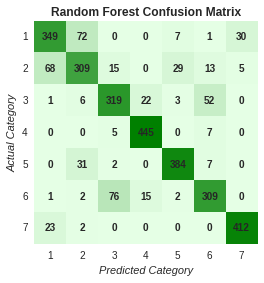

In [72]:
rf = RandomForestClassifier()
rf.fit(x, y)
pred_valid = rf.predict(valid_x)

cf = metrics.confusion_matrix(valid_y, pred_valid)
print "Accuracy: %.2f%%" % (metrics.accuracy_score(valid_y, pred_valid) * 100)

conf_arr = cf.tolist()
norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        if a == 0:
            tmp_arr.append(0)
        else:
            tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
cmap = sns.light_palette('green', as_cmap = True)
fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=cmap, 
                interpolation='nearest')

width = len(conf_arr)
height = len(conf_arr[0])

for x in xrange(width):
    for y in xrange(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center',
                    weight='bold')
plt.title('Random Forest Confusion Matrix',weight='bold')
plt.ylabel('Actual Category', style='italic')
plt.xlabel('Predicted Category',style='italic')
items = [1,2,3,4,5,6,7]
plt.xticks(range(width), items)
plt.yticks(range(height), items)
plt.grid(b = None)

#Choose Number of Estimators

In [96]:
n = xrange(50,1000,50)
mse_valid = []
accuracy_valid = []
mse_train = []
accuracy_train = []

for i in n:    
    rf = RandomForestClassifier(n_estimators=i,criterion='entropy')
    rf.fit(x, y)
    pred_valid = rf.predict(valid_x)
    pred_y = rf.predict(x)
    
    acc = metrics.accuracy_score(valid_y, pred_valid)
    print "N= %d, Accuracy on Validation: %f" % (i,acc)
    
    accuracy_valid.append(acc)
    mse_valid.append(metrics.mean_squared_error(valid_y, pred_valid))
    accuracy_train.append(metrics.accuracy_score(y, pred_y))
    mse_train.append(metrics.mean_squared_error(y, pred_y))

N= 50, Accuracy on Validation: 0.859127
N= 100, Accuracy on Validation: 0.862103
N= 150, Accuracy on Validation: 0.862434
N= 200, Accuracy on Validation: 0.868717
N= 250, Accuracy on Validation: 0.865079
N= 300, Accuracy on Validation: 0.863095
N= 350, Accuracy on Validation: 0.863095
N= 400, Accuracy on Validation: 0.863095
N= 450, Accuracy on Validation: 0.866071
N= 500, Accuracy on Validation: 0.868056
N= 550, Accuracy on Validation: 0.866071
N= 600, Accuracy on Validation: 0.864749
N= 650, Accuracy on Validation: 0.865741
N= 700, Accuracy on Validation: 0.864749
N= 750, Accuracy on Validation: 0.862765
N= 800, Accuracy on Validation: 0.862434
N= 850, Accuracy on Validation: 0.865741
N= 900, Accuracy on Validation: 0.864087
N= 950, Accuracy on Validation: 0.862765


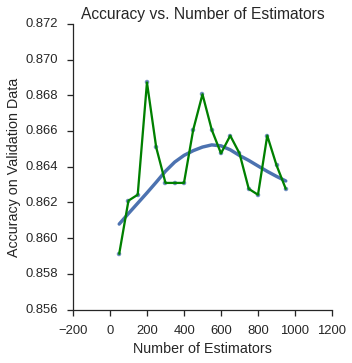

In [101]:
df = pd.DataFrame([n, accuracy_train, mse_train, accuracy_valid, mse_valid]).T
df.columns = ['n','accuracy_train','mse_train', 'accuracy_valid', 'mse_valid']

sns.set(style="ticks", context="talk")

#sns.lmplot(x = 'n', y = 'accuracy_train',data = df, lowess =True)
sns.lmplot(x = 'n', y = 'accuracy_valid',data = df, lowess =True)
#plt.plot(n, accuracy_train, 'g-')
plt.plot(n, accuracy_valid, 'g-')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy on Validation Data')
plt.title('Accuracy vs. Number of Estimators');

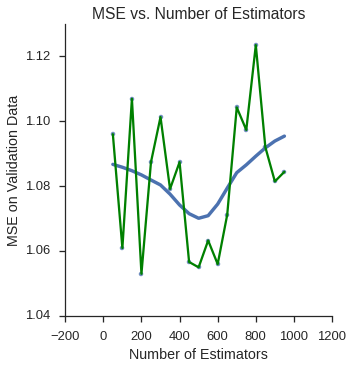

In [102]:
sns.lmplot(x = 'n', y = 'mse_valid',data = df, lowess =True)
plt.plot(n, mse_valid, 'g-')
plt.xlabel('Number of Estimators')
plt.ylabel('MSE on Validation Data')
plt.title('MSE vs. Number of Estimators');

train_sizes_abs, train_scores, test_scores = learning_curve(RandomForestClassifier(n_estimators=800, criterion='entropy'),x, y, cv = 3)

array([[ 0.72018159,  0.73719008,  0.74824308,  0.74803475,  0.72693422],
       [ 0.79075526,  0.79421488,  0.81727987,  0.79685561,  0.80513033],
       [ 0.81923236,  0.81487603,  0.83794957,  0.82498966,  0.82829954],
       [ 0.84110607,  0.8285124 ,  0.85448532,  0.83864295,  0.83988415],
       [ 0.85142385,  0.84090909,  0.85655229,  0.84898635,  0.85105503]])

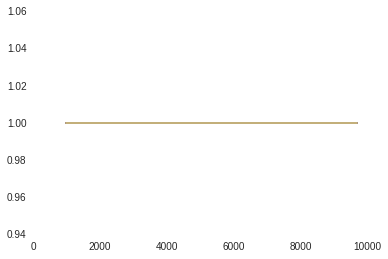

In [64]:
plt.plot(train_sizes_abs, train_scores)
test_scores

In [118]:
1024*12

12288

In [106]:
17*5

85

In [107]:
10.7/16

0.66875

In [109]:
32.2/48

0.6708333333333334

In [110]:
14.7*3

44.099999999999994

In [111]:
14.7/16

0.91875

In [112]:
11/16.0

0.6875

In [113]:
10.7/12.0

0.8916666666666666

In [115]:
14.5/16.0*12


10.875